In [360]:
# Importar o componente que retornará informarções de uma ação da bolsa de valores
from yahooquery import Ticker
# Componentes de analise
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
from pandas import json_normalize
import pandas as pd
import math



In [361]:
# Vamos fazer uma analise PETR4 (Petrobrás)
petr = Ticker("PETR4.SA")
petr_dados = petr.history(period="max")
petr_dados.index = petr_dados.index.unique(level='date')
petr_dados.index = pd.to_datetime(petr_dados.index)




In [362]:
petr_dados.head()

,volume,high,open,low,close,adjclose,dividends,splits
date,,,,,,,,
2000-01-03,3.538944e+10,5.875,5.875,5.875,5.875,2.139588,0.0,0.0
2000-01-04,2.886144e+10,5.550,5.550,5.550,5.550,2.021228,0.0,0.0
2000-01-05,4.303360e+10,5.494,5.494,5.494,5.494,2.000833,0.0,0.0
2000-01-06,3.405568e+10,5.475,5.475,5.475,5.475,1.993913,0.0,0.0
2000-01-07,2.091264e+10,5.500,5.500,5.500,5.500,2.003019,0.0,0.0


<AxesSubplot: xlabel='date'>

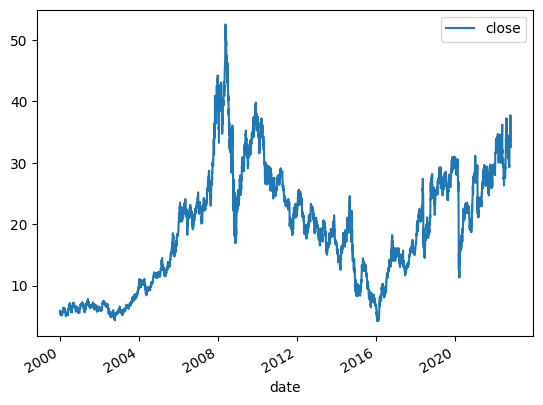

In [363]:
# Verificar a ação desde 2000
petr_dados[["close"]].plot()

<AxesSubplot: xlabel='date'>

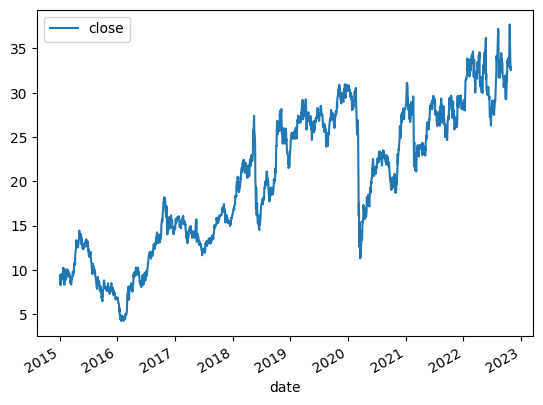

In [364]:
# Verificar a ação a partir 2015
petr_dados[petr_dados.index >= pd.to_datetime('2015-01-01')][["close"]].plot()

<AxesSubplot: xlabel='date'>

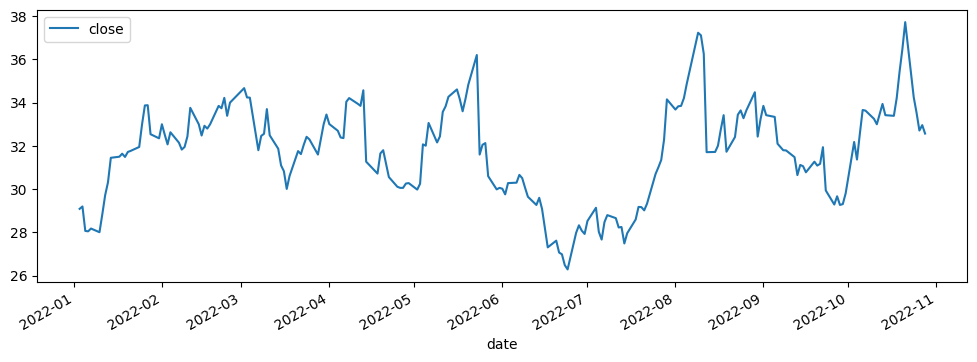

In [365]:
# Verificar a ação esse ano
fig, axs = plt.subplots(figsize=(12, 4))

petr_dados[petr_dados.index >= pd.to_datetime('2022-01-01')][["close"]].plot(ax=axs)

'----'

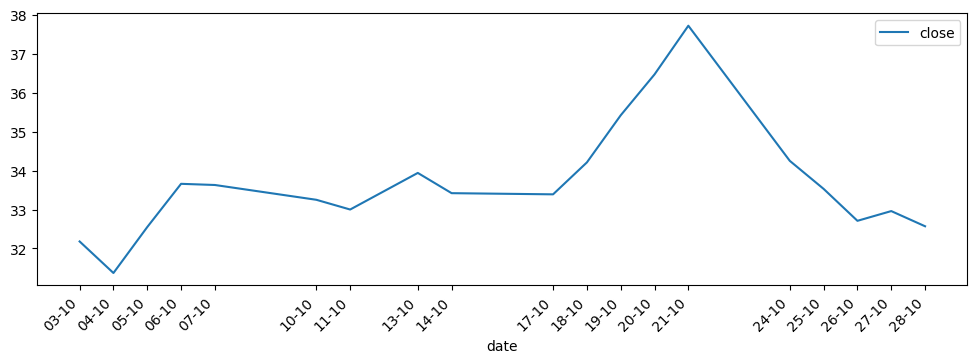

In [366]:
# Verificar o comportamento da ação no ultimo mês

fig, axs = plt.subplots(figsize=(12, 4))
dados_plot = petr_dados[petr_dados.index >= pd.to_datetime((datetime.now() - relativedelta(months=1)))][["close"]]
plot = dados_plot.plot(ax=axs)
x_labels = pd.to_datetime(dados_plot.index).strftime('%d-%m')


plot.set_xticks(dados_plot.index)
plot.set_xticklabels(x_labels, rotation=45)

"----"


In [367]:
# Analisar a base da SELIC

r = requests.get('https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json')
retorno_api = r.json()

dt_selic = json_normalize(retorno_api) 
dt_selic



,data,valor
0,04/06/1986,0.065041
1,05/06/1986,0.067397
2,06/06/1986,0.066740
3,09/06/1986,0.068247
4,10/06/1986,0.067041
...,...,...
9121,24/10/2022,0.050788
9122,25/10/2022,0.050788
9123,26/10/2022,0.050788
9124,27/10/2022,0.050788


In [368]:
# Transformar o retorno da API em uma série, pra se adaptar ao dataset da ação e para que possamos fazer algumas analises 

def converterDataObj(x):
    return datetime.strptime(x, "%d/%m/%Y")
dt_selic["valor"].index = dt_selic["data"].apply(converterDataObj)
dt_selic["valor"].index.names = ['date']

selic = pd.Series(dt_selic["valor"])
#Converter valores pra float

selic = pd.to_numeric(selic)
selic

date
1986-06-04    0.065041
1986-06-05    0.067397
1986-06-06    0.066740
1986-06-09    0.068247
1986-06-10    0.067041
                ...   
2022-10-24    0.050788
2022-10-25    0.050788
2022-10-26    0.050788
2022-10-27    0.050788
2022-10-28    0.050788
Name: valor, Length: 9126, dtype: float64

In [369]:
# Filtrar para apenas nos anos 2000 pra cima, pois é onde se inicia nosso dataset

selic = selic[selic.index >= pd.to_datetime('2000-01-01')]

<AxesSubplot: xlabel='date'>

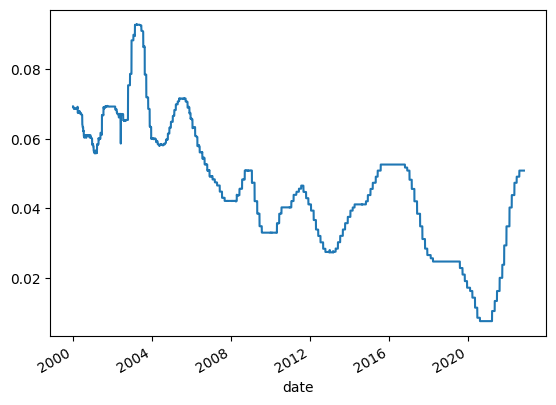

In [370]:
# Verificar o comportamento da SELIC durante os anos 

selic.plot()

In [371]:
# Unir selic com a base PETR4 

petr_dados = petr_dados.assign(selic = selic)

# Verificar se algum ficou em branco 

petr_dados.isna().sum()


volume        0
high          0
open          0
low           0
close         0
adjclose      0
dividends     0
splits        0
selic        62
dtype: int64

In [372]:
# verifiquei que será melhor fazer a predição dos ultimos dois anos, pois é onde houve uma oscilação menor 

petr_dados = petr_dados[petr_dados.index >= pd.to_datetime('2020-01-01')]


In [373]:
# Os em branco vou preencher com o ultimo valor

def preencherUltimoSelic (x):
     
    global selic     
    days = 1   
   
    while math.isnan(x['selic']):
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in selic.index :
            x['selic'] = selic.loc[atual]                  
        days += 1
    return x

selic_preenchidos = petr_dados[petr_dados["selic"].isna()].apply(preencherUltimoSelic, axis=1)

# depois que descobri os valores anteriores, vou preenchelos na base final

for index,value in selic_preenchidos.iterrows() :    
    petr_dados["selic"][index] = value['selic']

# por fim verificar se não há mais valores nulos

petr_dados.isna().sum()

volume       0
high         0
open         0
low          0
close        0
adjclose     0
dividends    0
splits       0
selic        0
dtype: int64

In [374]:
# Verificar correlação entre as colunas 

corr = petr_dados.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


C:\Users\gabri\AppData\Local\Temp\ipykernel_26804\682635969.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)
c:\Python310\lib\site-packages\pandas\io\formats\style.py:3925: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Python310\lib\site-packages\pandas\io\formats\style.py:3926: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,volume,high,open,low,close,adjclose,dividends,splits,selic
volume,1.00,-0.14,-0.17,-0.20,-0.17,-0.03,0.16,nan,0.03
high,-0.14,1.00,1.00,1.00,1.00,0.85,0.06,nan,0.71
open,-0.17,1.00,1.00,1.00,0.99,0.84,0.04,nan,0.70
low,-0.20,1.00,1.00,1.00,1.00,0.83,0.04,nan,0.69
close,-0.17,1.00,0.99,1.00,1.00,0.84,0.06,nan,0.70
adjclose,-0.03,0.85,0.84,0.83,0.84,1.00,0.10,nan,0.90
dividends,0.16,0.06,0.04,0.04,0.06,0.10,1.00,nan,0.09
splits,nan,nan,nan,nan,nan,nan,nan,nan,nan
selic,0.03,0.71,0.70,0.69,0.70,0.90,0.09,nan,1.00


In [375]:
# Como a ideia é tentar prever diáriamente o valor fechamento, vou criar 5 colunas 
# com a porcentagem de aumento ou diminuição da ação nos ultimos 5 dias do dia em questão,
# acredito que com isso consigo adicionar, alem do valor do selic consigo adicionar a influencia da queda ou valorizacao
# baseado se no passado ela foi valorizada ou não


numeroDiasAnteriores = 15
menorData = petr_dados.iloc[numeroDiasAnteriores].name
def preencherPorcentagemAumento (x):     
    global petr_dados,numeroDiasAnteriores,menorData 
    if x.name <= menorData:
        count = 1
        while count <= numeroDiasAnteriores:
            x['val'+str(count)] = 1
            count +=1
        return x
    
    days = 1       
    
    count = 1
    closeValue = [x['close']]
    while count <= numeroDiasAnteriores:
        x['val'+str(count)] = False
        while x['val'+str(count)] == False:    
            atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
            if atual in petr_dados.index :
                closeValue.append(petr_dados.loc[atual]['close'])           
                x['val'+str(count)] =  closeValue[-2] / closeValue[-1]          
            days += 1
        count +=1
    return x
 
petr_dados = petr_dados.apply(preencherPorcentagemAumento, axis=1)


In [376]:
# Vamos limpar as colunas que não usaremos 

petr_dados.drop(["open","high","low","volume","adjclose","splits","dividends"],axis=1,inplace=True)

petr_dados


,close,selic,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10
date,,,,,,,,,,,,
2020-01-02,30.700001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-03,30.450001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-06,30.809999,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-07,30.690001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-08,30.500000,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,34.250000,0.050788,0.908006,1.034275,1.029644,1.035370,1.024558,0.999102,0.984679,1.028485,0.992481,0.988701
2022-10-25,33.529999,0.050788,0.978978,0.908006,1.034275,1.029644,1.035370,1.024558,0.999102,0.984679,1.028485,0.992481
2022-10-26,32.709999,0.050788,0.975544,0.978978,0.908006,1.034275,1.029644,1.035370,1.024558,0.999102,0.984679,1.028485


In [377]:
# Escalar os dados

from sklearn.preprocessing import MinMaxScaler
petr_dados_formatado = pd.DataFrame()

#salvar o valor maximo pra ser usado posteriormente 
max_close = max(petr_dados["close"])

petr_dados_formatado["close"] = petr_dados["close"] / max(petr_dados["close"])
petr_dados_formatado["selic"] = petr_dados["selic"] / max(petr_dados["selic"])

count = 1
while count <= numeroDiasAnteriores:
    petr_dados_formatado['val'+str(count)] = petr_dados['val'+str(count)] / max(petr_dados['val'+str(count)])   
    count +=1

petr_dados_formatado
#scaler = MinMaxScaler(feature_range=(0,1))
#petr_dados_formatado = scaler.fit_transform(petr_dados)
#petr_dados_formatado

,close,selic,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10
date,,,,,,,,,,,,
2020-01-02,0.813892,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
2020-01-03,0.807264,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
2020-01-06,0.816808,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
2020-01-07,0.813627,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
2020-01-08,0.808590,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,0.908006,1.000000,0.742914,0.846225,0.842436,0.847121,0.838275,0.817447,0.805646,0.841488,0.812030,0.808937
2022-10-25,0.888918,1.000000,0.800982,0.742914,0.846225,0.842436,0.847121,0.838275,0.817447,0.805646,0.841488,0.812030
2022-10-26,0.867179,1.000000,0.798173,0.800982,0.742914,0.846225,0.842436,0.847121,0.838275,0.817447,0.805646,0.841488


In [378]:
# Separar treino e teste
from sklearn.model_selection import train_test_split

X = petr_dados_formatado.drop(["close"],axis=1)
y = petr_dados_formatado[["close"]]

training_data_len = int(np.ceil( len(petr_dados_formatado) * .80 ))

X_train = X[:training_data_len]
X_test = X[training_data_len:]
y_train = y[:training_data_len]
y_test = y[training_data_len:]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [385]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=500)

Epoch 1/500
3/3 [==============================] - 1s 17ms/step - loss: 0.2973
Epoch 2/500
3/3 [==============================] - 0s 17ms/step - loss: 0.0292
Epoch 3/500
3/3 [==============================] - 0s 18ms/step - loss: 0.0688
Epoch 4/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0154
Epoch 5/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0334
Epoch 6/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0343
Epoch 7/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0186
Epoch 8/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0163
Epoch 9/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0208
Epoch 10/500
3/3 [==============================] - 0s 21ms/step - loss: 0.0167
Epoch 11/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0148
Epoch 12/500
3/3 [==============================] - 0s 20ms/step - loss: 0.0161
Epoch 13/500
3/3 [==============================]

In [386]:
X_train

,selic,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10
date,,,,,,,,,,,
2020-01-02,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
2020-01-03,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
2020-01-06,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
2020-01-07,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
2020-01-08,0.336477,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.861207,0.810498,0.807419,0.829590,0.835660,0.836306,0.800450,0.815153,0.827627,0.829308,0.814575
2022-04-05,0.861207,0.810425,0.810498,0.807419,0.829590,0.835660,0.836306,0.800450,0.815153,0.827627,0.829308
2022-04-06,0.861207,0.817424,0.810425,0.810498,0.807419,0.829590,0.835660,0.836306,0.800450,0.815153,0.827627


In [387]:
# Verificar o erro do modelo

predictions = model.predict(X_test)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 0s 3ms/step


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


close    0.098158
dtype: float64

1/1 [==============================] - 0s 341ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_26804\3720208853.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions * max_close


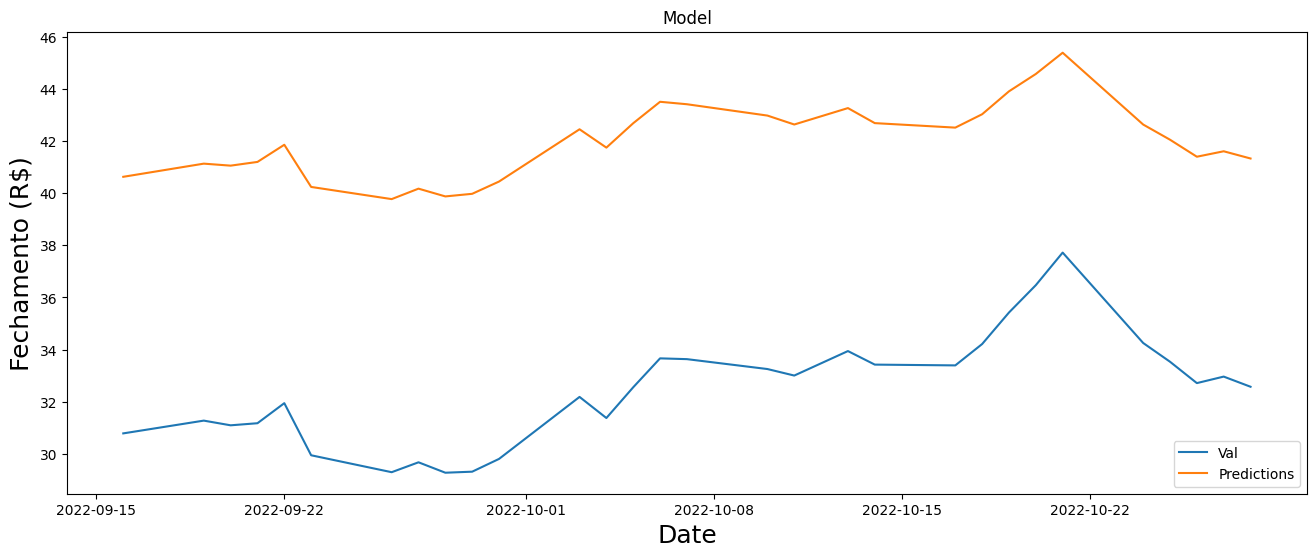

,close,selic,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,predictions
date,,,,,,,,,,,,,
2022-09-16,30.780001,0.050788,0.990985,0.998072,1.015334,0.973634,0.990248,0.999686,0.990654,0.962807,0.997606,0.987297,40.629276
2022-09-19,31.270000,0.050788,1.015919,0.990985,0.998072,1.015334,0.973634,0.990248,0.999686,0.990654,0.962807,0.997606,41.134560
2022-09-20,31.090000,0.050788,0.994244,1.015919,0.990985,0.998072,1.015334,0.973634,0.990248,0.999686,0.990654,0.962807,41.057674
2022-09-21,31.170000,0.050788,1.002573,0.994244,1.015919,0.990985,0.998072,1.015334,0.973634,0.990248,0.999686,0.990654,41.200596
2022-09-22,31.940001,0.050788,1.024703,1.002573,0.994244,1.015919,0.990985,0.998072,1.015334,0.973634,0.990248,0.999686,41.859158
2022-09-23,29.940001,0.050788,0.937383,1.024703,1.002573,0.994244,1.015919,0.990985,0.998072,1.015334,0.973634,0.990248,40.240269
2022-09-26,29.290001,0.050788,0.978290,0.937383,1.024703,1.002573,0.994244,1.015919,0.990985,0.998072,1.015334,0.973634,39.773289
2022-09-27,29.670000,0.050788,1.012974,0.978290,0.937383,1.024703,1.002573,0.994244,1.015919,0.990985,0.998072,1.015334,40.174541
2022-09-28,29.270000,0.050788,0.986518,1.012974,0.978290,0.937383,1.024703,1.002573,0.994244,1.015919,0.990985,0.998072,39.876461


In [388]:
# plotar o resultado dos testes
total = petr_dados_formatado.shape[0]
diasAnteriores = 30
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()
valid